Predict email opens
==================
Exploring the data
-------------

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pandasql
from time import time
from sklearn import feature_selection
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Read train data
train_data=pd.read_csv("training_dataset.csv")
test_data=pd.read_csv("test_dataset.csv")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486048 entries, 0 to 486047
Data columns (total 54 columns):
user_id                                 486048 non-null object
mail_id                                 486048 non-null object
mail_category                           485623 non-null object
mail_type                               485623 non-null object
sent_time                               486048 non-null int64
open_time                               161347 non-null float64
click_time                              27084 non-null float64
unsubscribe_time                        1958 non-null float64
last_online                             485471 non-null float64
hacker_created_at                       486048 non-null int64
hacker_timezone                         479109 non-null float64
clicked                                 486048 non-null bool
contest_login_count                     486048 non-null int64
contest_login_count_1_days              486048 non-null int64
contest_log

Data Preprocessing: Training Dataset
----------------
**There are 486048 sent emails in the training dataset. The labels are 'opened.' There are 4 features with less than 1.4% missing data: 'mail_category', 'mail_type', 'last_online', and 'hacker_timezone'. There are 3 features with very few not-null data: 'open_time', 'click_time', and 'unsubscribe_time'. These features, together with 'opened', 'clicked', and 'unsubscribed', are dropped because we don't have these features in the test_dataset.  **

In [3]:
# Drop features that are unique to training_dataset.csv except 'opened'

drop_features=['click_time','clicked','open_time','unsubscribe_time','unsubscribed']
train_data=train_data.drop(drop_features,axis=1)
train_labels=train_data['opened']
print "%d percent of sent emails will be opened. " %(100*train_labels.mean())

33 percent of sent emails will be opened. 


**Check user_id and mail_id, are there users in both train_dataset and test_dataset?**

In [4]:
train_email=set(train_data['mail_id'])
test_email=set(test_data['mail_id'])
print "Numbers of train emails: ",len(train_email)
print "Numbers of test emails: ",len(test_email)
print "emails only in train set: ",len(train_email-test_email)
print "emails only in test set: ",len(test_email-train_email)

print"\n"
test_users=set(test_data['user_id'])
train_users=set(train_data['user_id'])
print "Numbers of train users: ",len(train_users)
print "Numbers of test users: ",len(test_users)
print "Users only in test set: ",len(test_users-train_users)
print "Users only in train set: ",len(train_users-test_users)

Numbers of train emails:  164
Numbers of test emails:  57
emails only in train set:  107
emails only in test set:  0


Numbers of train users:  30538
Numbers of test users:  26877
Users only in test set:  902
Users only in train set:  4563


**I observed that all emails in the test dataset (57/57) have been sent in train dataset. Most users (25925/26877) in the test dataset appear in the train dataset. Intuitively, emails that have been opened more frequently will be opened more frequently, and users who have opened emails more frequently will be more likely to open emails.
There are two important features I'd like to include: 
**
- For each mail_id, calculate the propability it is opened in the train data set. 
- For each user_id, calculate the probability the user open an email in the train data set. 

**Emails get opened**

In [5]:
q_open_email='''
SELECT mail_id,COUNT(mail_id)
FROM train_data
WHERE opened==1
GROUP BY mail_id; 
'''
q_email='''
SELECT mail_id,COUNT(mail_id)
FROM train_data
GROUP BY mail_id;
'''
open_email=pandasql.sqldf(q_open_email.lower(),locals())
email=pandasql.sqldf(q_email.lower(),locals())

open_email.rename(columns={'count(mail_id)':'count_opened_email'},inplace=True)
email.rename(columns={'count(mail_id)':'count_email'},inplace=True)

#Join them
q_join_email='''
SELECT email.mail_id, open_email.count_opened_email, email.count_email
FROM email
LEFT JOIN open_email
ON email.mail_id=open_email.mail_id
'''
open_email_ratio=pandasql.sqldf(q_join_email.lower(),locals())

# If a mail_id has never been opened, fillna with 0
open_email_ratio['count_opened_email']=open_email_ratio['count_opened_email'].fillna(value=0)
# Calculate probability that the mail_id was opened
open_email_ratio['prob_this_mail_get_opened']=open_email_ratio['count_opened_email']/open_email_ratio['count_email']
open_email_ratio.describe()

,count_opened_email,count_email,prob_this_mail_get_opened
count,164.000000,164.000000,164.000000
mean,983.823171,2963.707317,0.368075
std,1918.037097,5469.277349,0.133105
min,0.000000,1.000000,0.000000
25%,105.750000,279.000000,0.297881
50%,243.000000,608.500000,0.350588
75%,674.250000,1821.250000,0.420925
max,10273.000000,26206.000000,1.000000


**Users open email**

In [6]:
q_user_open='''
SELECT user_id,COUNT(user_id)
FROM train_data
WHERE opened==1
GROUP BY user_id; 
'''
q_user='''
SELECT user_id,COUNT(user_id)
FROM train_data
GROUP BY user_id;
'''
user_open=pandasql.sqldf(q_user_open.lower(),locals())
user=pandasql.sqldf(q_user.lower(),locals())

user_open.rename(columns={'count(user_id)':'count_user_open'},inplace=True)
user.rename(columns={'count(user_id)':'count_user'},inplace=True)

#Join them
q_join_user='''
SELECT user.user_id, user_open.count_user_open, user.count_user
FROM user
LEFT JOIN user_open
ON user.user_id=user_open.user_id
'''
user_open_ratio=pandasql.sqldf(q_join_user.lower(),locals())

# If the user_id has never opened any email, fillna with 0
user_open_ratio['count_user_open']=user_open_ratio['count_user_open'].fillna(value=0)

# Calculate the probability that this user_id open an email
user_open_ratio['prob_this_user_open_email']=user_open_ratio['count_user_open']/user_open_ratio['count_user']

user_open_ratio.describe()

,count_user_open,count_user,prob_this_user_open_email
count,30538.000000,30538.000000,30538.000000
mean,5.283483,15.916170,0.321640
std,7.775384,12.427135,0.333344
min,0.000000,1.000000,0.000000
25%,0.000000,7.000000,0.000000
50%,2.000000,13.000000,0.210526
75%,7.000000,22.000000,0.548387
max,87.000000,106.000000,1.000000


In [7]:
# Drop columns
open_email_ratio=open_email_ratio.drop(['count_opened_email','count_email'],axis=1)
user_open_ratio=user_open_ratio.drop(['count_user_open','count_user'],axis=1)

In [8]:
q_email='''
SELECT *
FROM train_data
LEFT JOIN open_email_ratio
ON train_data.mail_id=open_email_ratio.mail_id
'''
train_1=pandasql.sqldf(q_email.lower(),locals())

q_user='''
SELECT * 
FROM train_1
LEFT JOIN user_open_ratio
ON train_1.user_id=user_open_ratio.user_id
'''
train_features=pandasql.sqldf(q_user.lower(),locals())

train_features=train_features.drop(['mail_id','user_id'],axis=1)

train_features.describe()

,sent_time,last_online,hacker_created_at,hacker_timezone,contest_login_count,contest_login_count_1_days,contest_login_count_30_days,contest_login_count_365_days,contest_login_count_7_days,contest_participation_count,...,submissions_count_contest_30_days,submissions_count_contest_365_days,submissions_count_contest_7_days,submissions_count_master,submissions_count_master_1_days,submissions_count_master_30_days,submissions_count_master_365_days,submissions_count_master_7_days,prob_this_mail_get_opened,prob_this_user_open_email
count,4.860480e+05,4.854710e+05,4.860480e+05,479109.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,...,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000
mean,1.460378e+09,1.459161e+09,1.439918e+09,5245.825063,3.696357,0.009674,0.524516,2.885806,0.162198,5.832628,...,1.598953,13.445485,0.486911,40.622459,0.154602,9.030365,35.104648,2.471916,0.331957,0.331957
std,2.143160e+06,3.300271e+06,2.278764e+07,17553.931062,7.689379,0.107343,0.904353,5.626671,0.443127,12.342502,...,7.868896,48.730845,3.246356,67.741608,1.365345,20.450653,58.196637,7.836031,0.056996,0.312646
min,1.455281e+09,1.376045e+09,1.336762e+09,-43200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.458833e+09,1.457689e+09,1.429803e+09,-14400.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.298758,0.055556
50%,1.460575e+09,1.459528e+09,1.448939e+09,18000.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,16.000000,0.000000,1.000000,14.000000,0.000000,0.330100,0.243243
75%,1.462287e+09,1.461237e+09,1.457395e+09,18000.000000,3.000000,0.000000,1.000000,3.000000,0.000000,5.000000,...,0.000000,5.000000,0.000000,48.000000,0.000000,9.000000,43.000000,1.000000,0.390283,0.550000
max,1.463529e+09,1.463524e+09,1.463368e+09,50400.000000,123.000000,4.000000,16.000000,94.000000,8.000000,214.000000,...,243.000000,1195.000000,167.000000,1310.000000,138.000000,641.000000,1310.000000,553.000000,1.000000,1.000000


In [9]:
train_features=train_features.drop(['opened'],axis=1)

**Let's deal with categorical features such as 'mail_category' and 'mail_type' using dummy variables. **

In [10]:
dummies_mailtype=pd.get_dummies(train_features['mail_type'],prefix='')
dummies_mailcategory=pd.get_dummies(train_features['mail_category'],prefix='')
train_features=pd.concat([train_features,dummies_mailtype,dummies_mailcategory],axis=1)
train_features=train_features.drop(['mail_type','mail_category'],axis=1)
train_features.describe()

,sent_time,last_online,hacker_created_at,hacker_timezone,contest_login_count,contest_login_count_1_days,contest_login_count_30_days,contest_login_count_365_days,contest_login_count_7_days,contest_participation_count,...,_mail_category_17,_mail_category_18,_mail_category_2,_mail_category_3,_mail_category_4,_mail_category_5,_mail_category_6,_mail_category_7,_mail_category_8,_mail_category_9
count,4.860480e+05,4.854710e+05,4.860480e+05,479109.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,...,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000,486048.000000
mean,1.460378e+09,1.459161e+09,1.439918e+09,5245.825063,3.696357,0.009674,0.524516,2.885806,0.162198,5.832628,...,0.001510,0.000019,0.010766,0.137196,0.086728,0.002467,0.027378,0.054886,0.006119,0.013299
std,2.143160e+06,3.300271e+06,2.278764e+07,17553.931062,7.689379,0.107343,0.904353,5.626671,0.443127,12.342502,...,0.038831,0.004303,0.103201,0.344055,0.281436,0.049606,0.163182,0.227757,0.077983,0.114552
min,1.455281e+09,1.376045e+09,1.336762e+09,-43200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.458833e+09,1.457689e+09,1.429803e+09,-14400.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.460575e+09,1.459528e+09,1.448939e+09,18000.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.462287e+09,1.461237e+09,1.457395e+09,18000.000000,3.000000,0.000000,1.000000,3.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.463529e+09,1.463524e+09,1.463368e+09,50400.000000,123.000000,4.000000,16.000000,94.000000,8.000000,214.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**We impute missing data in 'last_online' and 'hacker_time_zone' with the median values.** 

In [11]:
train_features['last_online']=train_features['last_online'].fillna(value=train_features['last_online'].median())
train_features['hacker_timezone']=train_features['hacker_timezone'].fillna(value=train_features['hacker_timezone'].median())

**The 'hacker_timezone' is actually ordinal. It should be transformed into dummy variables. **

In [12]:
timeZ=(train_features['hacker_timezone']/3600).astype(int)

temp=train_features.drop(['hacker_timezone'],axis=1)
train_X=pd.concat([temp,timeZ],axis=1)
dummies_timeZ=pd.get_dummies(train_X['hacker_timezone'],prefix='timezone')
temp2=pd.concat([train_X,dummies_timeZ],axis=1)
train_X=temp2.drop(['hacker_timezone'],axis=1)

**Count within N days (N=1, 7, 30, 365) are accumulated. It is hard to tell if a high count_365days is contributed by last day, last month, or other days. I took the difference. **

In [13]:
prefix=['contest_login_count_','contest_participation_count_','ipn_count_','ipn_read_',
        'submissions_count_','submissions_count_contest_','submissions_count_master_']
days=['1_days','7_days','30_days','365_days']
for pre in prefix:
    col=[]
    new_col_name=[]
    for day in days:
        col.append(pre+day)
        new_col_name.append(pre+day+'_d')
        
    train_X[new_col_name[0]]=train_X[col[0]]
    train_X[new_col_name[1]]=train_X[col[1]]-train_X[col[0]]
    train_X[new_col_name[2]]=train_X[col[2]]-train_X[col[1]]
    train_X[new_col_name[3]]=train_X[col[3]]-train_X[col[2]]
    train_X=train_X.drop(col,axis=1)

train_X.shape

(486048, 90)

Data Preprocessing: Test Dataset
-------------------------

In [14]:
# Add two new features: prob_this_mail_get_opened, prob_this_user_open_email

q_email='''
SELECT *
FROM test_data
LEFT JOIN open_email_ratio
ON test_data.mail_id=open_email_ratio.mail_id
'''
test_1=pandasql.sqldf(q_email.lower(),locals())

q_user='''
SELECT *
FROM test_1
LEFT JOIN user_open_ratio
ON test_1.user_id=user_open_ratio.user_id
'''
test_features=pandasql.sqldf(q_user.lower(),locals())

test_features=test_features.drop(['mail_id','user_id'],axis=1)

test_features.describe()

,sent_time,last_online,hacker_created_at,hacker_timezone,contest_login_count,contest_login_count_1_days,contest_login_count_30_days,contest_login_count_365_days,contest_login_count_7_days,contest_participation_count,...,submissions_count_contest_30_days,submissions_count_contest_365_days,submissions_count_contest_7_days,submissions_count_master,submissions_count_master_1_days,submissions_count_master_30_days,submissions_count_master_365_days,submissions_count_master_7_days,prob_this_mail_get_opened,prob_this_user_open_email
count,2.074240e+05,2.072910e+05,2.074240e+05,199784.000000,207424.000000,207424.0,207424.000000,207424.000000,207424.000000,207424.000000,...,207424.000000,207424.000000,207424.000000,207424.000000,207424.000000,207424.000000,207424.000000,207424.000000,207424.000000,202426.000000
mean,1.465592e+09,1.463267e+09,1.443770e+09,5593.258719,2.714884,0.0,0.109900,2.006494,0.003669,4.264444,...,1.082406,8.720654,0.206736,35.692037,0.017997,5.475678,30.389116,1.131788,0.309953,0.309200
std,1.255834e+06,2.458809e+06,2.263431e+07,17467.924264,5.882209,0.0,0.390369,3.932457,0.065142,9.449557,...,6.767871,36.300261,2.050423,61.700515,0.423033,15.764275,52.934097,4.857573,0.053555,0.319871
min,1.463530e+09,1.405174e+09,1.336762e+09,-43200.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.464470e+09,1.461654e+09,1.434170e+09,-14400.000000,1.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.265356,0.000000
50%,1.465559e+09,1.463487e+09,1.452946e+09,18000.000000,1.000000,0.0,0.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,10.000000,0.000000,0.305724,0.200000
75%,1.466661e+09,1.465028e+09,1.460452e+09,18000.000000,2.000000,0.0,0.000000,2.000000,0.000000,3.000000,...,0.000000,2.000000,0.000000,43.000000,0.000000,3.000000,37.000000,0.000000,0.339319,0.500000
max,1.467859e+09,1.467841e+09,1.463368e+09,50400.000000,123.000000,0.0,9.000000,94.000000,3.000000,214.000000,...,283.000000,1355.000000,214.000000,1471.000000,78.000000,472.000000,1471.000000,164.000000,0.396195,1.000000


In [15]:
#impute missing values in 'prob_this_user_open_email' with median()
test_features['prob_this_user_open_email']=test_features['prob_this_user_open_email'].fillna(value=test_features['prob_this_user_open_email'].median())

In [16]:
# Explore test_data
#test_data.info()

# Let's deal with categorical features such as 'mail_category' and 'mail_type' using dummy variables.
dummies_mailtype=pd.get_dummies(test_features['mail_type'],prefix='')
dummies_mailcategory=pd.get_dummies(test_features['mail_category'],prefix='')
test_data=pd.concat([test_features,dummies_mailtype,dummies_mailcategory],axis=1)
test_data=test_data.drop(['mail_type','mail_category'],axis=1)
#test_data.describe()

# We impute missing data in 'last_online' and 'hacker_time_zone' with the median values.
test_data['last_online']=test_data['last_online'].fillna(value=test_data['last_online'].median())
test_data['hacker_timezone']=test_data['hacker_timezone'].fillna(value=test_data['hacker_timezone'].median())

# The 'hacker_timezone' is actually ordinal. It should be transformed into dummy variables.
timeZ=(test_data['hacker_timezone']/3600).astype(int)
temp=test_data.drop(['hacker_timezone'],axis=1)
test_X=pd.concat([temp,timeZ],axis=1)
dummies_timeZ=pd.get_dummies(test_X['hacker_timezone'],prefix='timezone')
temp2=pd.concat([test_X,dummies_timeZ],axis=1)
test_X=temp2.drop(['hacker_timezone'],axis=1)


# Count within N days (N=1, 7, 30, 365) are accumulated. 
# It is hard to tell if a high count_365days is contributed by last day, last month, or other days. 
# I took the difference. 
prefix=['contest_login_count_','contest_participation_count_','ipn_count_','ipn_read_',
        'submissions_count_','submissions_count_contest_','submissions_count_master_']
days=['1_days','7_days','30_days','365_days']
for pre in prefix:
    col=[]
    new_col_name=[]
    for day in days:
        col.append(pre+day)
        new_col_name.append(pre+day+'_d')
        
    test_X[new_col_name[0]]=test_X[col[0]]
    test_X[new_col_name[1]]=test_X[col[1]]-test_X[col[0]]
    test_X[new_col_name[2]]=test_X[col[2]]-test_X[col[1]]
    test_X[new_col_name[3]]=test_X[col[3]]-test_X[col[2]]
    test_X=test_X.drop(col,axis=1)


#test_X.info()
print "Test shape: \t",test_X.columns.values.shape
print "Train shape:\t",train_X.columns.values.shape
missing_col=set(train_X.columns.values)-set(test_X.columns.values)
print missing_col


Test shape: 	(83,)
Train shape:	(90,)
set([u'_mail_category_13', u'_mail_category_17', u'_mail_category_15', u'_mail_category_18', u'_mail_type_2', u'_mail_type_3', u'_mail_type_4'])


**There are 7 missing columns (categorical) in test_X. Remove these columns in train_X.**

In [17]:
train_X=train_X.drop(list(missing_col),axis=1)

**Make sure that columns order is the same as train_X.**

In [18]:
test_X=test_X[train_X.columns.values]

Training and Testing Data Split
-----------
Approximately 33% emails will be opened. Thus, use stratified shuffle split for unbalanced training dataset. 

In [23]:
# Shuffle and split the train dataset 
S=StratifiedShuffleSplit(train_labels,n_iter=1,test_size=0.1,random_state=3)
for train_ind,test_ind in S:
    X_train,X_test=train_X.iloc[train_ind],train_X.iloc[test_ind]
    y_train,y_test=train_labels.iloc[train_ind],train_labels.iloc[test_ind]

Feature Selection as Part of a Pipeline
------------


In [24]:
#dt_clf=DecisionTreeClassifier(random_state=3)
#dt_clf.fit(X_train,y_train)

et_clf=ExtraTreesClassifier(random_state=3)
et_clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)

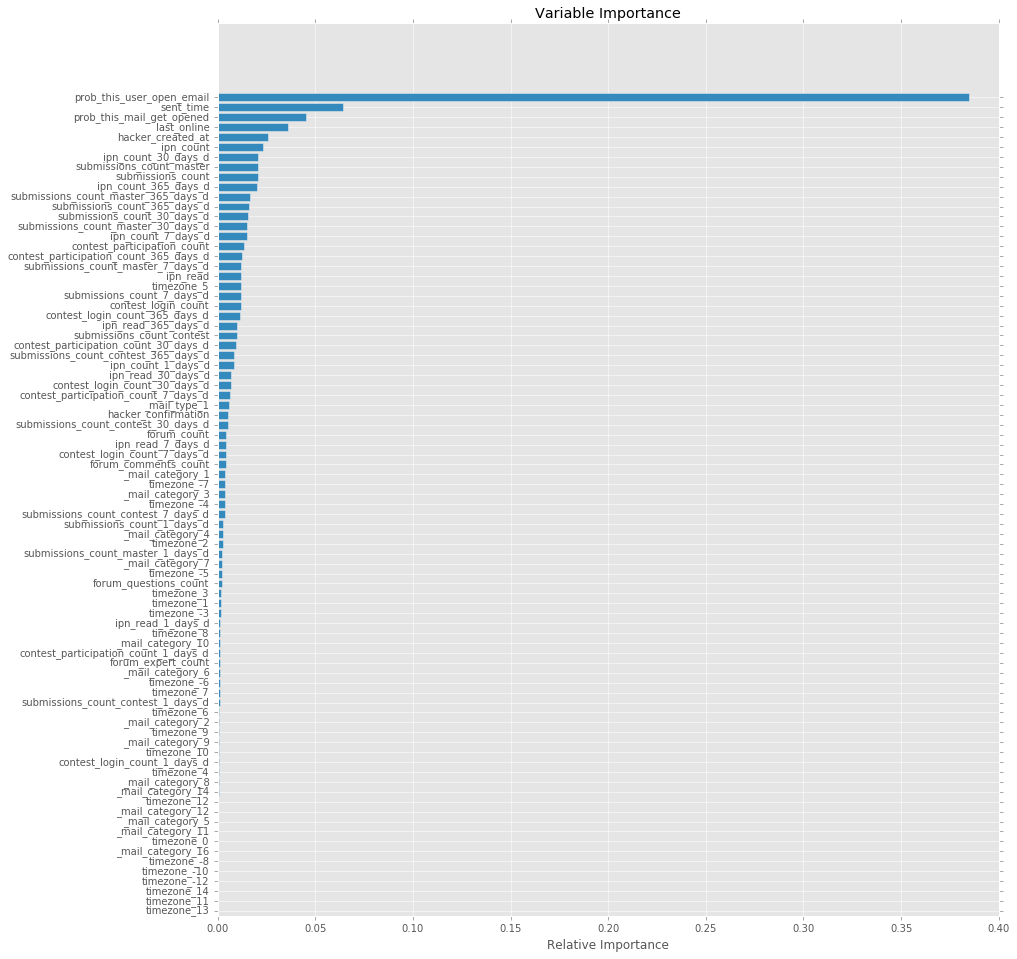

In [25]:
importances=et_clf.feature_importances_
sort_ind=np.argsort(importances)
pad=np.arange(len(X_train.columns.values))+0.5
plt.figure(figsize=(14,16))
plt.barh(pad,importances[sort_ind],align='center')
plt.xlabel("Relative Importance")
plt.yticks(pad,X_train.columns.values[sort_ind])
plt.title("Variable Importance")
plt.savefig('Importances.png')
plt.show()


Training and Evaluating Models
------------------


In [26]:
#Helper functions

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

**Try the following models: ExtraTrees, Random Forest, Bagging, AdaBoost, GradientBoosting. **
- KNeighbors terribly underfit
- SVM takes forever (cannot deal with more than 10,000 samples)

In [28]:
# Using selector  
#selector=feature_selection.SelectFromModel(et_clf)
'''
scores=[]
k_ranges=range(22,27)
for kk in k_ranges:
    selector=feature_selection.SelectKBest(feature_selection.chi2,k=kk)

    clf=ExtraTreesClassifier(n_jobs=-1,random_state=3)#, RandomForestClassifier(n_jobs=-1,random_state=3)]

    pipe_clf=Pipeline([('feature_selection',selector),('classification',clf)])
    #print "TRAINING CLASSIFIER:\T ",str(clf)
    pipe_clf.fit(X_train,y_train)
    pred=pipe_clf.predict(X_test)
    #train_predict(pipe_clf,X_train,y_train,X_test,y_test)
    #print "\n"
    scores.append(f1_score(y_test,pred))
'''    

'''
plt.figure(figsize=(14,5))
plt.plot(k_ranges,scores)
plt.ylabel("F1_scores(test)")
#plt.yticks(pad,k_ranges)
plt.title("Select k best features")
plt.show()
'''
'''
selectK=feature_selection.SelectKBest(feature_selection.chi2,k=25).fit(X_train,y_train)
X_train_new=selectK.transform(X_train)
X_test_new=selectK.transform(X_test)


# K best and than Extreme tree selector...WORSE
#et_clf=ExtraTreesClassifier(random_state=3)
#et_clf.fit(X_train_new,y_train)
#selector=feature_selection.SelectFromModel(et_clf)

TreesCLFs=[ExtraTreesClassifier(random_state=3)]

for clf in TreesCLFs:
    pipe_clf=Pipeline([('classification',clf)]) 
    print "TRAINING CLASSIFIER:\T ",str(clf)
    for size in [len(X_train)]:
        X=X_train_new[:size]
        y=y_train[:size]
        train_predict(pipe_clf,X,y,X_test_new,y_test)
    print "\n"
'''

'\nselectK=feature_selection.SelectKBest(feature_selection.chi2,k=25).fit(X_train,y_train)\nX_train_new=selectK.transform(X_train)\nX_test_new=selectK.transform(X_test)\n\n\n# K best and than Extreme tree selector...WORSE\n#et_clf=ExtraTreesClassifier(random_state=3)\n#et_clf.fit(X_train_new,y_train)\n#selector=feature_selection.SelectFromModel(et_clf)\n\nTreesCLFs=[ExtraTreesClassifier(random_state=3)]\n\nfor clf in TreesCLFs:\n    pipe_clf=Pipeline([(\'classification\',clf)]) \n    print "TRAINING CLASSIFIER:\\T ",str(clf)\n    for size in [len(X_train)]:\n        X=X_train_new[:size]\n        y=y_train[:size]\n        train_predict(pipe_clf,X,y,X_test_new,y_test)\n    print "\n"\n'

In [31]:
# Extreme tree selector ...
#et_clf=ExtraTreesClassifier(random_state=3)
#et_clf.fit(X_train,y_train)
selector=feature_selection.SelectFromModel(et_clf)

TreesCLFs=[AdaBoostClassifier(random_state=3),GradientBoostingClassifier(random_state=3), RandomForestClassifier(random_state=3), BaggingClassifier(random_state=3)]

for clf in TreesCLFs:
    pipe_clf=Pipeline([('select',selector),('classification',clf)]) 
    print "TRAINING CLASSIFIER:\T ",str(clf)
    for size in [len(X_train)]:
        X=X_train[:size]
        y=y_train[:size]
        train_predict(pipe_clf,X,y,X_test,y_test)
    print "\n"

TRAINING CLASSIFIER:\T  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)
Training a Pipeline using a training set size of 437443. . .
Trained model in 51.8586 seconds
Made predictions in 2.6652 seconds.
F1 score for training set: 0.7124.
Made predictions in 0.3081 seconds.
F1 score for test set: 0.7103.


TRAINING CLASSIFIER:\T  GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=3, subsample=1.0, verbose=0,
              warm_start=False)
Training a Pipeline using a training set size of 437443. . .
Trained model in 134.7255 seconds
Made predictions in 1.0872 seconds.
F1 score for training set: 0.7163.
Made predictions in 0.1757 seconds.
F1 score for test set: 0.7123.


In [33]:
# Using selector and reducer...WORSE  
# Use gradient boosting selectors
ab_clf=AdaBoostClassifier(random_state=3)
ab_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)

In [34]:
selector=feature_selection.SelectFromModel(ab_clf)

TreesCLFs=[AdaBoostClassifier(random_state=3),GradientBoostingClassifier(random_state=3)]

for clf in TreesCLFs:
    pipe_clf=Pipeline([('feature_selection',selector),('classification',clf)]) #('reducer',PCA()), WORSE
    print "TRAINING CLASSIFIER:\T ",str(clf)
    for size in [200000,len(X_train)]:
        X=X_train[:size]
        y=y_train[:size]
        train_predict(pipe_clf,X,y,X_test,y_test)
    print "\n"

TRAINING CLASSIFIER:\T  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)
Training a Pipeline using a training set size of 200000. . .
Trained model in 28.0358 seconds
Made predictions in 1.0181 seconds.
F1 score for training set: 0.7158.
Made predictions in 0.2299 seconds.
F1 score for test set: 0.7126.
Training a Pipeline using a training set size of 437443. . .
Trained model in 74.9169 seconds
Made predictions in 2.5137 seconds.
F1 score for training set: 0.7158.
Made predictions in 0.2289 seconds.
F1 score for test set: 0.7116.


TRAINING CLASSIFIER:\T  GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=3, subsample=1.0, verbose=0,
              warm_start=False)
T

**PCA dimensional reduction is worse. Averaging methods such as Bagging, Random Forest, and ExtraTrees are overfitting. I decide to tune AdaBoostClassifer and GradientBoostingClassifier with an AdaBoost importances selector (F1 score is approximately the same as GradientBoostingClassifier but faster). The F1-scores for training and testing are 0.7158 and 0.7126, respectively. The model performance does not increase as the sample size increases. **
Model Tuning
----------
GridSearchCV and StratifiedShuffleSplit

In [38]:
cv_sets=StratifiedShuffleSplit(y_train,n_iter=5,test_size=0.2)

f1_scorer=make_scorer(f1_score)

pipeline=Pipeline([('feature_selection',selector),('Ada',AdaBoostClassifier())])
print "Start training..."

parameters={'Ada__n_estimators':[50,100,150,200]}

####
t_start=time()

# Perform grid search on the classifier using the f1_score as the scoring method
grid_obj0=GridSearchCV(pipeline,parameters,scoring=f1_scorer,cv=cv_sets)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj0=grid_obj0.fit(X_train,y_train)

# Get the best estimator
best_clf=grid_obj0.best_estimator_
print best_clf
#
y_pred=best_clf.predict(X_test)
print "F1-score (test):\t",f1_score(y_test,y_pred)
t_end=time()

print "Time spent for training:\t",(t_end-t_start)

Start training...
Pipeline(steps=[('feature_selection', SelectFromModel(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3),
        prefit=False, threshold=None)), ('Ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
F1-score (test):	0.711565654905
Time spent for training:	1469.77726817


In [41]:
cv_sets=StratifiedShuffleSplit(y_train,n_iter=5,test_size=0.2)

f1_scorer=make_scorer(f1_score)

pipeline=Pipeline([('feature_selection',selector),('GB',GradientBoostingClassifier())])
print "Start training..."

parameters={'GB__learning_rate':[0.1,0.2,0.5]}

####
t_start=time()

# Perform grid search on the classifier using the f1_score as the scoring method
grid_obj1=GridSearchCV(pipeline,parameters,scoring=f1_scorer,cv=cv_sets)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj1=grid_obj0.fit(X_train,y_train)

# Get the best estimator
best_clf1=grid_obj1.best_estimator_
print best_clf1
#
y_pred=best_clf1.predict(X_test)
print "F1-score (test):\t",f1_score(y_test,y_pred)
t_end=time()

print "Time spent for training:\t",(t_end-t_start)

Start training...
Pipeline(steps=[('feature_selection', SelectFromModel(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3),
        prefit=False, threshold=None)), ('GB', GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])
F1-score (test):	0.715003828356
Time spent for training:	1257.43685603


In [44]:
grid_obj0.grid_scores_

[mean: 0.71507, std: 0.00120, params: {'GB__learning_rate': 0.1},
 mean: 0.71531, std: 0.00071, params: {'GB__learning_rate': 0.2},
 mean: 0.71602, std: 0.00039, params: {'GB__learning_rate': 0.5}]

**More trees (n_estimators=100), better hold-out F1-score (0.6125). Gini is a better criterion.**

Final Model
----------
Use all training_dataset for the training steps.

In [54]:
t_5=time()
ab_clf=AdaBoostClassifier()
ab_clf.fit(train_X,train_labels)
selector=feature_selection.SelectFromModel(ab_clf)
t_4=time()
print "Time for features selection:\t",(t_4-t_5)

cv_sets=StratifiedShuffleSplit(train_labels,n_iter=10,test_size=0.2)
pipeline=Pipeline([('feature_selection',selector),('AB',AdaBoostClassifier())])
parameters={'AB__learning_rate':[0.4,0.6,0.8],'AB__n_estimators':[50,75,100]}

t_3=time()
# Perform grid search on the classifier using the f1_score as the scoring method
grid_objf=GridSearchCV(pipeline,parameters,scoring=f1_scorer,cv=cv_sets)

t_2=time()
print "Time for GridSearchCV:\t",(t_2-t_3)

# Fit the grid search object to the training data and find the optimal parameters
grid_objf=grid_objf.fit(train_X,train_labels)

# Get the best estimator
final_clf=grid_objf.best_estimator_
print final_clf

t_1=time()
print "Time for training:\t",(t_1-t_2)
#print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
#print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))


Time for features selection:	62.4859619141
Time for GridSearchCV:	8.60691070557e-05
Pipeline(steps=[('feature_selection', SelectFromModel(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
        prefit=False, threshold=None)), ('AB', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.6, n_estimators=50, random_state=None))])
Time for training:	6257.06763697


**I'll keep this final_clf for users from the test_dataset who did not appear in train_dataset.**

Make Prediction for Submission
------------------------

In [55]:
result=final_clf.predict(test_X)

In [56]:
result_int=[int(x == True) for x in result]

In [57]:
for x in result_int:
    if x!=0 and x!=1:
        print x

In [58]:
# Write the test results
output=pd.DataFrame(data={"opened":result_int})
output.to_csv("prediction.csv",index=False,header=False)